In [1]:
!ls data

random_paths_benchmark.csv  santa_cities.csv


In [2]:
!head data/santa_cities.csv

In [3]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#from concorde.tsp import TSPSolver

In [4]:
df = pd.read_csv("data/santa_cities.csv") # index_col="id"
df

,id,x,y
0,0,4360,6178
1,1,10906,14956
2,2,5071,8963
3,3,13853,4105
4,4,18885,3168
...,...,...,...
149995,149995,7585,1056
149996,149996,13993,1775
149997,149997,13820,16485
149998,149998,16927,595


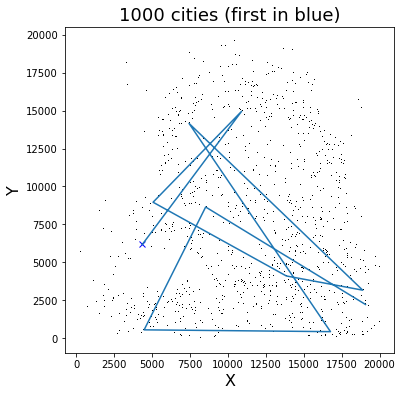

In [5]:
plt.figure(figsize=(6,6))
plt.subplot(111, adjustable='box', aspect=1.0)
plt.plot(df[:1000].x, df[:1000].y, 'k,')
plt.plot(df.x[0], df.y[0], 'bx')
plt.plot(df.x[:10], df.y[:10])
plt.xlabel('X', fontsize=16)
plt.ylabel('Y', fontsize=16)
plt.title('1000 cities (first in blue)', fontsize=18)
plt.show()

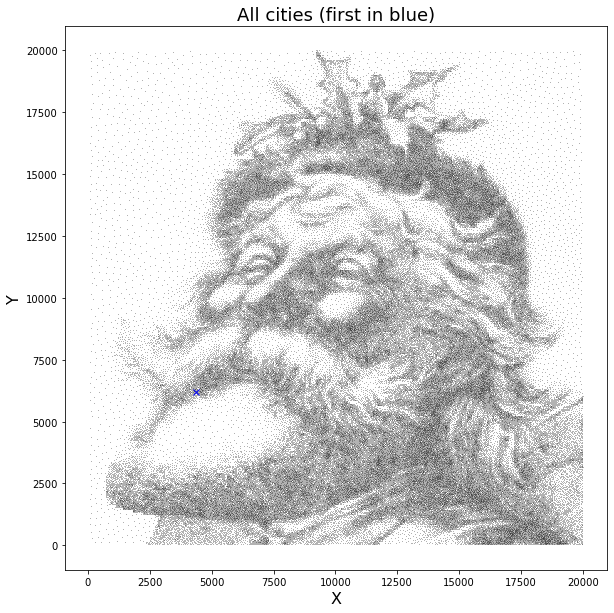

In [6]:
plt.figure(figsize=(16,10))
plt.subplot(111, adjustable='box', aspect=1.0)
plt.plot(df.x, df.y, 'k,', alpha=0.3)
plt.plot(df.x[0], df.y[0], 'bx')
plt.xlabel('X', fontsize=16)
plt.ylabel('Y', fontsize=16)
plt.title('All cities (first in blue)', fontsize=18)
plt.show()

In [7]:
xy = np.array([df.x.values, df.y.values]).T
xy

array([[ 4360,  6178],
       [10906, 14956],
       [ 5071,  8963],
       ...,
       [13820, 16485],
       [16927,   595],
       [ 9141, 13286]])

In [8]:
myDF = df[:100]

In [9]:
myDF

,id,x,y
0,0,4360,6178
1,1,10906,14956
2,2,5071,8963
3,3,13853,4105
4,4,18885,3168
...,...,...,...
95,95,4971,8004
96,96,8114,9885
97,97,9531,5061
98,98,17835,359


In [10]:
from scipy.spatial import distance_matrix

dist = distance_matrix(myDF.values, myDF.values)
dist.shape

(100, 100)

In [1]:
def plot_path(path, size=10):
    df_path = pd.merge(pd.DataFrame({'id':path}), myDF, on='id', how="left")
    
    plt.figure(figsize=(size,size))
    plt.subplot(111, adjustable='box', aspect=1.0)
    plt.plot(df_path.x, df_path.y)
    plt.plot(myDF.x[0], myDF.y[0], 'bx')
    plt.title(str(len(path))+' cities', fontsize=18)
    plt.show()

# Greedy: Nearest Neighbour

In [20]:
def nearest_neighbour(df):
    ids = df.index.values
    xy = np.array([df.x.values, df.y.values]).T
    path = [0,]
    while len(ids) > 0:
        last_x, last_y = df.x[path[-1]], df.x[path[-1]]
        dist = ((xy - np.array([last_x, last_y]))**2).sum(-1)
        nearest_index = dist.argmin()
        path.append(ids[nearest_index])
        ids = np.delete(ids, nearest_index, axis=0)
        xy  = np.delete(xy,  nearest_index, axis=0)
    path.append(0)
    return path

In [21]:
path = nearest_neighbour(myDF)
path[:5], path[-5:]

([0, 0, 94, 42, 73], [6, 51, 98, 47, 0])

In [2]:
plot_path(path, size=6)

NameError: name 'path' is not defined

# Greedy: Biclustering

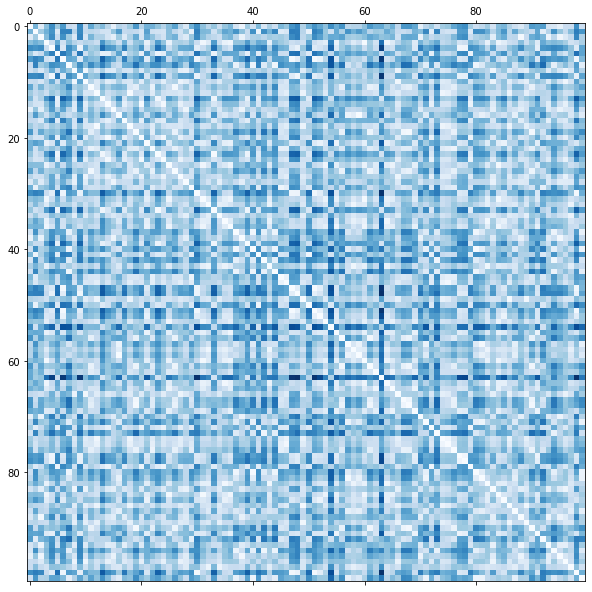

In [18]:
plt.figure(figsize=(10,10))
plt.matshow(dist, cmap=plt.cm.Blues, fignum=1)

In [34]:
from scipy.cluster.hierarchy import linkage

# Sort pairwise distance matrix
# https://gist.github.com/nlgranger/8989c74012b0f32fcda21c7d42307d75
def sort(m):
    y = m[np.triu_indices(len(m), k=1)]
    Z = linkage(y, method='single', optimal_ordering=True)
    perm = np.ravel(Z[:, :2]).astype(np.int32)
    perm = perm[perm < len(m)]
    return perm, m[perm][:, perm]

[59 16 12 18 33 23 40 80 20 14  3 60 86 49 51 47 68 19 57 81 98 30  6 88
  2 24 31 84 25 90 46 75 95 38 35 82 26 11 64 66 10 89 61 56 67  7 44  8
 94 42 48  9 43 58 37 93 55 36 53 74 13 96  4 77 78 83 50 41 73 79 72 39
 32 71 99  1 29 45 27 15 28 70 91 22 76 97 21 34  5 69 85 52  0 65 62 17
 87 92 54 63]


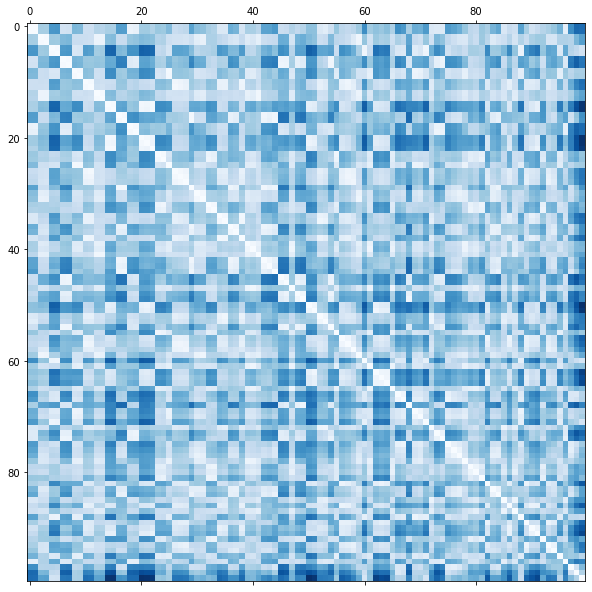

In [39]:
perm, sorted_dist = sort(dist)
print(perm)


plt.matshow(sorted_dist, cmap=plt.cm.Blues, fignum=1)

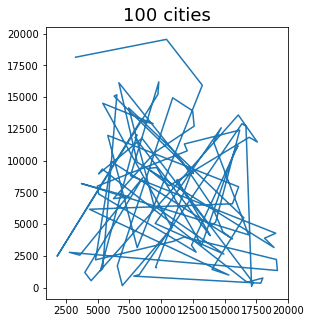

In [50]:
def plot_path(path, size=10):
    df_path = pd.merge(pd.DataFrame({'id':path}), myDF, on='id', how="left")
    
    plt.figure(figsize=(size,size))
    plt.subplot(111, adjustable='box', aspect=1.0)
    plt.plot(df_path.x, df_path.y)
    plt.title(str(len(path))+' cities', fontsize=18)
    plt.show()

plot_path(perm, size=5)

In [7]:
from sklearn.cluster import SpectralCoclustering, SpectralBiclustering

In [9]:
model = SpectralCoclustering(n_clusters=5, random_state=0)
model.fit(dist)

SpectralCoclustering(n_clusters=5, random_state=0)

In [11]:
model.row_labels_, model.column_labels_

(array([1, 3, 2, 2, 0, 4, 0, 1, 3, 2, 4, 3, 0], dtype=int32),
 array([0, 2, 3, 3, 1, 0, 4, 0, 2, 3, 0, 2, 1], dtype=int32))

In [ ]:
model = SpectralBiclustering(n_clusters=(4, 3), method='log', random_state=0)


In [20]:
np.triu_indices(len(m))

(array([  0,   0,   0, ..., 498, 498, 499]),
 array([  0,   1,   2, ..., 498, 499, 499]))

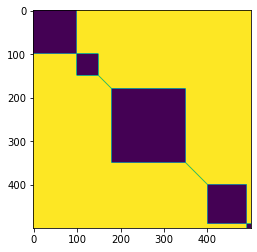

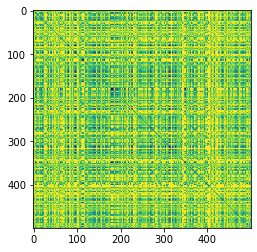

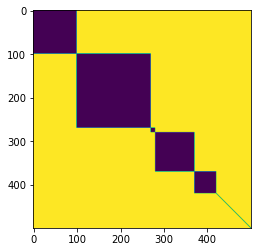

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.hierarchy import linkage

# distance matrix
m = np.zeros((500, 500))
m[:100, :100] = 1
m[100:150, 100:150] = 1
m[180:350, 180:350] = 1
m[400:490, 400:490] = 1
m[490:, 490:] = 1
m = 1 - m
m[np.arange(500), np.arange(500)] = 0

plt.figure()
plt.imshow(m)

# shuffle
perm = np.random.permutation(len(m))
m = m[perm][:, perm]

plt.figure()
plt.imshow(m)

# reorder
y = m[np.triu_indices(len(m), k=1)]
Z = linkage(y, method='single', optimal_ordering=True)
perm = np.ravel(Z[:, :2]).astype(np.int32)
perm = perm[perm < len(m)]
m = m[perm][:, perm]

plt.figure()
plt.imshow(m)